<h1 align=right> Document Pivot ( Identification of most important/common Topics accross corpus. ) <h1> 

- [Phase 1](): Data Cleaning

- [Phase 2](): WorldCould and TF-IDF building

- [Phase 3](): Kmeans Clustering and visulaizing categories & associated terms

# Phase 1: Data Cleaning

### Step 1: Setting up TensorFlow and Colab Runtime

Go to above menu bar and select `Runtime` then from Dropdown menu select `change runtime type` and then choose `GPU` from that to enable it . Lastly try to connect GPU with `Connect` button at upper right corner of notebook otherwise it will automatically connect once you execute a cell.

In [ ]:
import tensorflow as tf
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")
!nvidia-smi

GPU is available
Fri Nov  5 11:52:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

## Step 2: Connecting Google drive and importing Packages

We need to mount Google Drive in order to get access to data files as Colab can't browse from local PC files. For that we need to first upload our data in drive then we'll mount our drive here to browse through files there.

All the packages are imported below, try "pip install package_name" in case you don't have any installed.  

In [ ]:
## Mounting google drive
from google.colab import drive
drive.mount('gdrive') 

Mounted at gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab DataSets/upwork_data/

/content/gdrive/MyDrive/Colab DataSets/upwork_data


In [ ]:
# Importing basic packages
import sqlite3
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 22)
pd.set_option('display.width',1000)
pd.set_option('max_colwidth', 1000) 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Importing NLP related packages
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stpwrds = set(stopwords.words('english'))
stpwrds.discard('not')
stpwrds.discard('no')
import spacy
nlp = spacy.load('en_core_web_sm')
import numpy as np
import nltk
import spacy
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(len(stop_words))

# Other supportive packages
import warnings
from warnings import filterwarnings
filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
179


## Step 3: Loading Data 

Our Data is in google drive and we will read it as a pandas dataframe for ease of exploration as well as cleaning 

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab DataSets/upwork_data/50kLanguage.csv", encoding = "ISO-8859-1")
df.head(6)

,User,UserID,UserTweets,UserFavorites,UserListed,UserFollowers,UserFriends,UserSince,UserSince(Year),UserLanguage,UserLocation,UserTimezone,UserUTCOffset,TimeOfTweet,TweetLanguage,TweetApp,TweetLocation,IsRetweet,TweetID,TweetURL,Tweet
0,lorenmonte,1.769682e+07,45291,16746,25,1480,1576,Fri Nov 28 02:42:08 +0000 2008,2008,pt,Brazil,Greenland,-10800.0,Mon Mar 05 03:59:40 +0000 2018,pt,Twitter Web Client,NaN,0,9.705090e+17,http://twitter.com/statuses/970509122549448704,EntÃ£o tem Chris Walken e nÃ£o tem dueto de danÃ§a com Sam Rockwell?!? Chateada #Oscars #Oscars90
1,thesilverfury,8.906480e+17,3682,2891,0,36,12,Thu Jul 27 18:59:05 +0000 2017,2017,en,NaN,NaN,NaN,Mon Mar 05 03:59:51 +0000 2018,en,Twitter for Android,NaN,0,9.705090e+17,http://twitter.com/statuses/970509167709405184,FINALLY!! THE SHAPE OF WATER WON!!!!! #Oscars
2,angelalfredos,7.044450e+17,15715,53685,0,149,1225,Mon Feb 29 23:13:59 +0000 2016,2016,es,"El Cine, Mexico",NaN,NaN,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for Android,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122494873601,RT @TheAcademy: And the Oscar goes to... https://t.co/968zIJ8n7D
3,IndeCardio,2.882972e+09,343449,92777,684,17257,17420,Tue Nov 18 18:26:59 +0000 2014,2014,en,NaN,NaN,NaN,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for Android,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122499153921,RT @realDonaldTrump: I should host the #Oscars just to shake things up - this is not good!
4,RyanCradduck,2.282597e+09,1048,147,5,362,1034,Wed Jan 08 20:30:32 +0000 2014,2014,en,"Lethbridge, Alberta",Pacific Time (US & Canada),-28800.0,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for Android,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122629070848,RT @TheAcademy: And the Oscar goes to... https://t.co/968zIJ8n7D
5,allyobrien,4.501076e+07,61460,28059,55,836,858,Fri Jun 05 22:08:46 +0000 2009,2009,en,hufflepuff,Eastern Time (US & Canada),-18000.0,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122641842176,"RT @BroadwayGirlNYC: Iâm just saying, if thereâs one thing this #oscars intro needs, itâs #morecowbell https://t.co/VoHlk4HgEk"


## Step 4: General Statistics
1.  [Data types]()

     Often, it is useful to understand what data we are dealing with, as the data types might end up causing errors into our analysis at a later stage.

2.  [Missing data]()

      We are also concerned we have a lot of missing data so we can check how much of our data is missing.

3. [Data statistics]() 

In [ ]:
print(df.shape)
df.info()

(49372, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49372 entries, 0 to 49371
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User             49372 non-null  object 
 1   UserID           49372 non-null  float64
 2   UserTweets       49372 non-null  int64  
 3   UserFavorites    49372 non-null  int64  
 4   UserListed       49372 non-null  int64  
 5   UserFollowers    49372 non-null  int64  
 6   UserFriends      49372 non-null  int64  
 7   UserSince        49372 non-null  object 
 8   UserSince(Year)  49372 non-null  int64  
 9   UserLanguage     49372 non-null  object 
 10  UserLocation     37201 non-null  object 
 11  UserTimezone     36132 non-null  object 
 12  UserUTCOffset    36132 non-null  float64
 13  TimeOfTweet      49372 non-null  object 
 14  TweetLanguage    49372 non-null  object 
 15  TweetApp         49372 non-null  object 
 16  TweetLocation    1055 non-null   object 
 17  

In [ ]:
pd.DataFrame({'DTYPES' : df.dtypes , 'Nulls': df.isnull().sum() , "Null_percentage":df.isnull().sum()/len(df.index) * 100})

,DTYPES,Nulls,Null_percentage
User,object,0,0.000000
UserID,float64,0,0.000000
UserTweets,int64,0,0.000000
UserFavorites,int64,0,0.000000
UserListed,int64,0,0.000000
UserFollowers,int64,0,0.000000
UserFriends,int64,0,0.000000
UserSince,object,0,0.000000
UserSince(Year),int64,0,0.000000
UserLanguage,object,0,0.000000


In [ ]:
# Visualizing a random sample of data
df.sample(20)

,User,UserID,UserTweets,UserFavorites,UserListed,UserFollowers,UserFriends,UserSince,UserSince(Year),UserLanguage,UserLocation,UserTimezone,UserUTCOffset,TimeOfTweet,TweetLanguage,TweetApp,TweetLocation,IsRetweet,TweetID,TweetURL,Tweet
45043,lauratsuner,1.125842e+08,70038,14770,0,759,188,Tue Feb 09 01:18:09 +0000 2010,2010,en,In A Galaxy Far Far Away,Mexico City,-21600.0,Mon Mar 05 04:03:01 +0000 2018,en,Twitter for iPhone,NaN,1,9.705100e+17,http://twitter.com/statuses/970509964379918338,"RT @SOMEXlCAN: Coco's "" Remember Me"" Performance Stage ððð #Oscars https://t.co/S1YqliRuqV"
13810,tomtuv,3.243359e+08,10002,5590,8,309,185,Sun Jun 26 12:34:16 +0000 2011,2011,fr,"Lyon, France",Paris,3600.0,Mon Mar 05 04:00:35 +0000 2018,no,Twitter for iPhone,NaN,0,9.705090e+17,http://twitter.com/statuses/970509354226118657,Alexandre Desplat. â¤ï¸ #Oscars
26860,Milly_E8,8.909858e+07,3835,1607,2,553,1052,Wed Nov 11 03:38:56 +0000 2009,2009,es,"Nevada, USA",Pacific Time (US & Canada),-28800.0,Mon Mar 05 04:01:30 +0000 2018,es,Twitter for iPhone,NaN,1,9.705100e+17,http://twitter.com/statuses/970509582312251392,RT @MagytaStar: Momentos que hay que ver una y otra y otra vez #UnaMujerFantastica #Oscars ð ð https://t.co/jZKGsRYGfr
2579,mariaasuareez,9.152560e+17,150,415,0,36,65,Tue Oct 03 16:43:37 +0000 2017,2017,es,"Ponferrada, EspaÃ±a",NaN,NaN,Mon Mar 05 03:59:51 +0000 2018,es,Twitter for Android,NaN,0,9.705090e+17,http://twitter.com/statuses/970509168472985600,ALELUYA LA FORMA DEL AGUA A MEJOR BANDA SONORA YASSS #Oscars #Oscars90 #oscar2018
3936,jkarpsportsfan1,3.159267e+08,13977,8710,28,1703,427,Sun Jun 12 17:30:03 +0000 2011,2011,en,"St Peters, MO",Central Time (US & Canada),-21600.0,Mon Mar 05 03:59:57 +0000 2018,en,Twitter for Android,NaN,0,9.705090e+17,http://twitter.com/statuses/970509191180881920,Christopher Walken makes any show/program better. #Oscars
9663,MollyVegas,3.684841e+08,108828,5049,44,1799,1863,Mon Sep 05 18:25:13 +0000 2011,2011,en,NaN,Eastern Time (US & Canada),-18000.0,Mon Mar 05 04:00:19 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509284407676929,RT @NayaRivera: I just love Sandra Bullock #oscars
36698,NXR90,1.246366e+09,57119,25782,75,652,477,Wed Mar 06 15:37:37 +0000 2013,2013,fr,"Paris, France",Paris,3600.0,Mon Mar 05 04:02:17 +0000 2018,fr,Twitter Web Client,NaN,0,9.705100e+17,http://twitter.com/statuses/970509781193682944,"Alexandre Desplat remporte son 2e Oscar aprÃ¨s celui pour ""The Grand Budapest Hotel"" #Oscars90 https://t.co/uC2PxMcKrK"
992,m__o___11,2.876382e+09,12358,24084,1,185,499,Sat Oct 25 06:55:43 +0000 2014,2014,ja,NaN,NaN,NaN,Mon Mar 05 03:59:45 +0000 2018,en,Twitter for Android,NaN,1,9.705090e+17,http://twitter.com/statuses/970509142698766336,RT @TheAcademy: And the Oscar goes to... https://t.co/N43iPPBFkz
48822,Izandra,3.470215e+07,226228,149301,14,272,608,Thu Apr 23 19:23:26 +0000 2009,2009,en,https://snackduchess.tumblr.com/,Pacific Time (US & Canada),-28800.0,Mon Mar 05 04:03:14 +0000 2018,en,Twitter for iPhone,NaN,1,9.705100e+17,http://twitter.com/statuses/970510021489389568,"RT @Variety: .@maryjblige, the first person ever to be nominated for #Oscars for both acting and original song in a single film, on the redâ¦"
10958,marcoalovaldez,1.800204e+08,8450,1184,5,488,1155,Wed Aug 18 17:10:35 +0000 2010,2010,es,NaN,Central Time (US & Canada),-21600.0,Mon Mar 05 04:00:24 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509306117279744,RT @TheAcademy: And the Oscar goes to... https://t.co/N43iPPBFkz


In [ ]:
# We are able to see lot of languages but we'll use only "english"
df['TweetLanguage'].value_counts()

en     29698
es      9616
pt      4941
ja      1279
und     1187
th       456
it       375
fr       292
nl       288
ar       192
de       154
tl       119
ru       107
in        98
ro        84
ht        80
tr        78
no        55
fi        43
et        38
pl        38
da        20
hi        18
sv        17
cy        16
ko        16
hu        12
ta        10
eu         9
el         8
fa         5
is         5
lt         3
kn         3
vi         2
zh         2
mr         2
cs         2
ml         1
ne         1
uk         1
lv         1
Name: TweetLanguage, dtype: int64

In [ ]:
# Here we will select only English language
df = df[df['TweetLanguage'] == str('en')]
df = df.reset_index()
df.shape

(29698, 22)

In [ ]:
df.head(20)

,index,User,UserID,UserTweets,UserFavorites,UserListed,UserFollowers,UserFriends,UserSince,UserSince(Year),UserLanguage,UserLocation,UserTimezone,UserUTCOffset,TimeOfTweet,TweetLanguage,TweetApp,TweetLocation,IsRetweet,TweetID,TweetURL,Tweet
0,1,thesilverfury,8.906480e+17,3682,2891,0,36,12,Thu Jul 27 18:59:05 +0000 2017,2017,en,NaN,NaN,NaN,Mon Mar 05 03:59:51 +0000 2018,en,Twitter for Android,NaN,0,9.705090e+17,http://twitter.com/statuses/970509167709405184,FINALLY!! THE SHAPE OF WATER WON!!!!! #Oscars
1,2,angelalfredos,7.044450e+17,15715,53685,0,149,1225,Mon Feb 29 23:13:59 +0000 2016,2016,es,"El Cine, Mexico",NaN,NaN,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for Android,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122494873601,RT @TheAcademy: And the Oscar goes to... https://t.co/968zIJ8n7D
2,3,IndeCardio,2.882972e+09,343449,92777,684,17257,17420,Tue Nov 18 18:26:59 +0000 2014,2014,en,NaN,NaN,NaN,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for Android,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122499153921,RT @realDonaldTrump: I should host the #Oscars just to shake things up - this is not good!
3,4,RyanCradduck,2.282597e+09,1048,147,5,362,1034,Wed Jan 08 20:30:32 +0000 2014,2014,en,"Lethbridge, Alberta",Pacific Time (US & Canada),-28800.0,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for Android,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122629070848,RT @TheAcademy: And the Oscar goes to... https://t.co/968zIJ8n7D
4,5,allyobrien,4.501076e+07,61460,28059,55,836,858,Fri Jun 05 22:08:46 +0000 2009,2009,en,hufflepuff,Eastern Time (US & Canada),-18000.0,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122641842176,"RT @BroadwayGirlNYC: Iâm just saying, if thereâs one thing this #oscars intro needs, itâs #morecowbell https://t.co/VoHlk4HgEk"
5,6,logiccjr,7.726090e+17,3546,4439,0,272,248,Mon Sep 05 01:34:55 +0000 2016,2016,en,301,NaN,NaN,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122666991616,"RT @ABC: Kobe Bryant accepts #Oscar for Best Animated Short: ""As basketball players, we're really supposed to shut up and dribble. But I'mâ¦"
6,7,Qboydaprince,1.255722e+08,20498,3035,3,434,375,Tue Mar 23 06:12:39 +0000 2010,2010,en,"Madison, WI-Port Elizabeth, ZA",Central Time (US & Canada),-21600.0,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122679472128,RT @BleacherReport: Amazing. #Oscars https://t.co/xoK6HBHM69
7,8,Pili_inLA,2.294768e+07,1467,569,10,164,516,Thu Mar 05 17:27:55 +0000 2009,2009,en,Los Angeles,Pacific Time (US & Canada),-28800.0,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122700435456,RT @nowthisnews: Jordan Peele is the first Black person to win the Academy Award for Best Original Screenplay ð#Oscars https://t.co/JDl0kdyâ¦
8,9,angstymuppet,3.072369e+09,13048,24420,8,528,1347,Thu Mar 05 13:09:56 +0000 2015,2015,en,dilapidated barn,NaN,NaN,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122708918278,RT @TheAcademy: And the Oscar goes to... https://t.co/N43iPPBFkz
9,12,Al_PMA91,6.003109e+08,33873,90238,4,769,2384,Tue Jun 05 18:28:52 +0000 2012,2012,en,NaN,Central Time (US & Canada),-21600.0,Mon Mar 05 03:59:40 +0000 2018,en,Twitter for iPhone,NaN,1,9.705090e+17,http://twitter.com/statuses/970509122864058369,"RT @girlposts: ""Why did Meryl Streep attended the ceremony dressed as the Fairy godmother from Shrek?"" #Oscars https://t.co/i5VdbvJNqZ"


## Step 5: Data cleaning


There are many techniques one can use to clean textual data. We will use most common cleansing methods ( see below function for cleaning! ) . We will also customizely clean our data based on subject matter knowledge. 

In [ ]:
# importing beautiful Soup for HTML parset
from bs4 import BeautifulSoup
import string
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
 def clean_non_english(text):
  """
  This function will clean re-tweets, URL's, HTML tags, Emojis, # tags, 
  Puntuations, Numbers/digits, extra whitespaces, REGEX parsing, stopwords, 
  single char. words & oscar word 
  """




  ## For removing re-tweets
  clean_words = re.sub(r"@\S+", "", str(text))

  ## For removing URL's 
  url_words = re.sub(r"http\S+", "", clean_words)
  

  ## For removing HTML tags using beautiful soup
  soup = BeautifulSoup(url_words, "html.parser")
  stripped_text = soup.get_text(separator=" ")
  

  ## Removing emojis from text
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

  clean_words = emoji_pattern.sub(r'', stripped_text)


  ## For removing digits/number
  words = re.sub(r'[0-9]+',"", clean_words)


  ## For removing Puntuations
  regex = re.compile('[%s]' % re.escape(string.punctuation))
  clean_words = regex.sub('', words)


  ## For removing extra spaces from text
  clean_words = re.sub(' +', ' ', clean_words)



  # Regex parsing
  # It will remove everything from text except a-z,A-z & 0-9 digits 
  final_words = re.sub('[^a-zA-z0-9\s]', ' ', clean_words)
  final_words = " ".join(w for w in final_words.split() if w not in stop_words)


  ## Removing single character words except i.
  final_words = " ".join(w.lower() for w in final_words.split())
  l1 = ['a','b','c','d','e','f','g','h','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  final_words = " ".join(w for w in final_words.split() if not len(w) == 1 or not w in l1)
  final_words = re.sub(r'rt','',str(final_words))
  

  ## making oscar a singular word and removing records having only oscar word in them.
  final_words = re.sub(r'oscars','oscar',final_words)
  words = " ".join(w for w in final_words.split() if not len(final_words.split()) <= 1 or not str(w) == 'oscar')


  ## Striping and removing extra white spaces
  
  final_words = words.strip()
  final_words = re.sub(' +', ' ', final_words)
  #final_words = re.sub(r'rt','',str(final_words))
  
  ## Removing oscar word and any extra space from text
  final_words = re.sub(r"oscar", "", str(final_words))
  final_words = re.sub(' +', ' ', final_words)
  


  return final_words

df['Tweet'][100:150].apply(clean_non_english)

100                                                                         and goes
101                      best original score goes alexandre desplat the shape water 
102                   i cant fit jeans high school rita moreno wearing dress wore go
103           twitter aired best commercial ever poetic stunning beautiful hereweare
104                                               ahhhh slayed performance thisisme 
105                                       we we yes jordan yes get get out yassssss 
106                                                                         and goes
107                                            nesse fim de semana goes lionel messi
108                                                                         and goes
109                                                          i moved to tears keala 
110                                                                           bravo 
111                                             congratulations m

In [ ]:
df['Tweet'][100:150]

100                                                                                      RT @TheAcademy: And the Oscar goes to... https://t.co/968zIJ8n7D
101                                     Oscar for Best Original Score goes to Alexandre Desplat for The Shape of Water. #Oscars90 https://t.co/QWDtV8yA5v
102        RT @goldengateblond: I can't fit into jeans from high school and Rita Moreno is wearing the same dress she wore to the #Oscars in 1962. #goâ¦
103                      RT @eugenegu: Twitter aired the best #Oscars commercial ever. Poetic and stunning. Beautiful. #HereWeAre https://t.co/ofI4TpmghW
104                                                                                Ahhhh @kealasettle just slayed that performance ð­ #ThisIsMe #Oscars
105                                  RT @LoveBrownSugar: We won! WE won. Yes Jordan yes. Get the F out! Get Out! Yassssss #oscars https://t.co/MZA8x2X0yr
106                                                                         

In [ ]:
## Creating new column for Cleaned tweets just randomly initializing with uncleaned tweets for sake of creation
df['Clean_tweets'] = df['Tweet']
print(df['Clean_tweets'].shape)
df['Clean_tweets'][0:5] = df['Tweet'][0:5]

(29698,)


In [ ]:
## It would take some time (few minutes) , I'll be tracking the overall progress by taking 100 records at a time.
## Now here i have taken 500 records at a time + checking time for every loop iteration . 
## A person can customize it by taking 2000,5000 or 10,000 . Depending on system it may change
## Here I 29650 value in loop now 29500 is divisible on 500 thats why as soon as we encounter 29500 records our loop will end
## by running last iteration of remaining records ( it's obvious that remaining records will be less then 500)
## A person can customize it by taking his data and checking the divisible of it based on 500,2000,5000 etc so that remaining records 
## will end the loop after execution
from time import time

i = 0
j = 500
t = time()
for k in range(len(df)):
  if i < 29500:
    print("We are at [{}:{}] loc and {}th iteration of total 59 epochs , time spent {} secs ... \
            ".format(i,j,k,np.round((time()-t))))
    df['Clean_tweets'][i:j] = df['Tweet'][i:j].apply(clean_non_english)
  else:
    print("Last iteration !!!!!")
    df['Clean_tweets'][i:] = df['Tweet'][i:].apply(clean_non_english)

    break

  i+=500
  j+=500  


df.head(6)

We are at [0:500] loc and 0th iteration of total 59 epochs , time spent 0.0 secs ...             
We are at [500:1000] loc and 1th iteration of total 59 epochs , time spent 0.0 secs ...             
We are at [1000:1500] loc and 2th iteration of total 59 epochs , time spent 0.0 secs ...             
We are at [1500:2000] loc and 3th iteration of total 59 epochs , time spent 1.0 secs ...             
We are at [2000:2500] loc and 4th iteration of total 59 epochs , time spent 1.0 secs ...             
We are at [2500:3000] loc and 5th iteration of total 59 epochs , time spent 1.0 secs ...             
We are at [3000:3500] loc and 6th iteration of total 59 epochs , time spent 1.0 secs ...             
We are at [3500:4000] loc and 7th iteration of total 59 epochs , time spent 1.0 secs ...             
We are at [4000:4500] loc and 8th iteration of total 59 epochs , time spent 1.0 secs ...             
We are at [4500:5000] loc and 9th iteration of total 59 epochs , time spent 2.0 secs ..

,Tweet,Clean_tweets
0,FINALLY!! THE SHAPE OF WATER WON!!!!! #Oscars,finally the shape of water won
1,RT @TheAcademy: And the Oscar goes to... https://t.co/968zIJ8n7D,and goes
2,RT @realDonaldTrump: I should host the #Oscars just to shake things up - this is not good!,i host shake things good
3,RT @TheAcademy: And the Oscar goes to... https://t.co/968zIJ8n7D,and goes
4,"RT @BroadwayGirlNYC: Iâm just saying, if thereâs one thing this #oscars intro needs, itâs #morecowbell https://t.co/VoHlk4HgEk",i saying one thing intro needs morecowbell
5,"RT @ABC: Kobe Bryant accepts #Oscar for Best Animated Short: ""As basketball players, we're really supposed to shut up and dribble. But I'mâ¦",kobe bryant accepts best animated sho as basketball players really supposed shut dribble but im


## Step 6: Dropping Columns 

Dropping un necessary columns for further analysis. In our case we will only keep textual columns as we only want to know text patterns and topics available across our whole data 

In [ ]:
names = df.columns[0:-1]
print(names)
df.drop(columns = names, inplace = True)
print(df.shape)
df.head(2)


Index(['index', 'User', 'UserID', 'UserTweets', 'UserFavorites', 'UserListed', 'UserFollowers', 'UserFriends', 'UserSince', 'UserSince(Year)', 'UserLanguage', 'UserLocation', 'UserTimezone', 'UserUTCOffset', 'TimeOfTweet', 'TweetLanguage', 'TweetApp', 'TweetLocation', 'IsRetweet', 'TweetID', 'TweetURL'], dtype='object')
(29698, 1)


,Tweet
0,FINALLY!! THE SHAPE OF WATER WON!!!!! #Oscars
1,RT @TheAcademy: And the Oscar goes to... https://t.co/968zIJ8n7D


In [ ]:
## Creating length column that will later on be used to drop records having very small text in them
def check_len(text):
  length = len(text.split())
  return length

df['length'] = df['Clean_tweets'].apply(check_len)
min(df['length'])

0

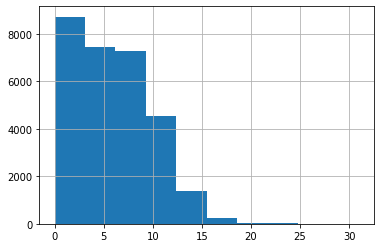

In [ ]:
## Checking overall distribution of length accross all tweets
df['length'].hist()

In [ ]:
## Let's remove those columns which do not have any text
df2 = df[df['length'] > 3]
len(df2)

20975

In [ ]:
df2.head(25)

,Tweet,Clean_tweets,length
0,FINALLY!! THE SHAPE OF WATER WON!!!!! #Oscars,finally the shape of water won,6
2,RT @realDonaldTrump: I should host the #Oscars just to shake things up - this is not good!,i host shake things good,5
4,"RT @BroadwayGirlNYC: Iâm just saying, if thereâs one thing this #oscars intro needs, itâs #morecowbell https://t.co/VoHlk4HgEk",i saying one thing intro needs morecowbell,7
5,"RT @ABC: Kobe Bryant accepts #Oscar for Best Animated Short: ""As basketball players, we're really supposed to shut up and dribble. But I'mâ¦",kobe bryant accepts best animated sho as basketball players really supposed shut dribble but im,15
7,RT @nowthisnews: Jordan Peele is the first Black person to win the Academy Award for Best Original Screenplay ð#Oscars https://t.co/JDl0kdyâ¦,jordan peele first black person win academy award best original screenplay,11
9,"RT @girlposts: ""Why did Meryl Streep attended the ceremony dressed as the Fairy godmother from Shrek?"" #Oscars https://t.co/i5VdbvJNqZ",why meryl streep attended ceremony dressed fairy godmother shrek,9
10,RT @cnni: âBlade Runner 2049â wins best cinematography #Oscars https://t.co/QI4p52dEfK https://t.co/sl4gmctmBb,blade runner wins best cinematography,5
11,Christopher Walken is really qualified to present the Oscar for Best Score because he knows truly great music involves more cowbell. #Oscars,christopher walken really qualified present best score knows truly great music involves cowbell,13
13,RT @enews: Coco takes home Best Animated Feature Film at the #Oscars! https://t.co/zmRVB0ydHq https://t.co/idiDVYWb3H,coco takes home best animated feature film,7
16,"Zendaya walking on the stage like Pitch Black's dark horses, leaving her dress in the air like Pitch Black's horsesâ¦ https://t.co/Wjw5ivWiHw",zendaya walking stage like pitch blacks dark horses leaving dress air like pitch blacks horses,15


## Step 7: Pickling

Finally we save our cleaned data in pickle format (.pkl) . Pickling is very important when you are working on a big project with continous intervals. It saves time by saving our efforts so far we have done and then continuing back again where we left by loading our cleaned data. The same technique can be done at many other intervals: after data cleaning, after EDA, after Feature Engineering etc 

In [ ]:
PICKLE_TRAIN_DIR = os.path.join("/content/gdrive/MyDrive/Colab DataSets/", "upwork_data", "clean_20k_tweets.pkl")

pd.to_pickle(df2, PICKLE_TRAIN_DIR)
print(len(df2))

20975


# - [Phase 2](): WorldCould and TF-IDF building


First we will import our data from directory of saving 

In [ ]:
PICKLE_TRAIN_DIR = os.path.join("/content/gdrive/MyDrive/Colab DataSets/", "upwork_data", "clean_20k_tweets.pkl")


df = pd.read_pickle(PICKLE_TRAIN_DIR)
print(df.shape)
df.head(10)

(20975, 3)


,Tweet,Clean_tweets,length
0,FINALLY!! THE SHAPE OF WATER WON!!!!! #Oscars,finally the shape of water won,6
2,RT @realDonaldTrump: I should host the #Oscars just to shake things up - this is not good!,i host shake things good,5
4,"RT @BroadwayGirlNYC: Iâm just saying, if thereâs one thing this #oscars intro needs, itâs #morecowbell https://t.co/VoHlk4HgEk",i saying one thing intro needs morecowbell,7
5,"RT @ABC: Kobe Bryant accepts #Oscar for Best Animated Short: ""As basketball players, we're really supposed to shut up and dribble. But I'mâ¦",kobe bryant accepts best animated sho as basketball players really supposed shut dribble but im,15
7,RT @nowthisnews: Jordan Peele is the first Black person to win the Academy Award for Best Original Screenplay ð#Oscars https://t.co/JDl0kdyâ¦,jordan peele first black person win academy award best original screenplay,11
9,"RT @girlposts: ""Why did Meryl Streep attended the ceremony dressed as the Fairy godmother from Shrek?"" #Oscars https://t.co/i5VdbvJNqZ",why meryl streep attended ceremony dressed fairy godmother shrek,9
10,RT @cnni: âBlade Runner 2049â wins best cinematography #Oscars https://t.co/QI4p52dEfK https://t.co/sl4gmctmBb,blade runner wins best cinematography,5
11,Christopher Walken is really qualified to present the Oscar for Best Score because he knows truly great music involves more cowbell. #Oscars,christopher walken really qualified present best score knows truly great music involves cowbell,13
13,RT @enews: Coco takes home Best Animated Feature Film at the #Oscars! https://t.co/zmRVB0ydHq https://t.co/idiDVYWb3H,coco takes home best animated feature film,7
16,"Zendaya walking on the stage like Pitch Black's dark horses, leaving her dress in the air like Pitch Black's horsesâ¦ https://t.co/Wjw5ivWiHw",zendaya walking stage like pitch blacks dark horses leaving dress air like pitch blacks horses,15


## Step 8: Word Cloud

Word Cloud is an amazing tool to present the text in amazing visual way . The way it represnts each word bigger or smaller is because 
of it's importance/occurence accross the text document. 

In [ ]:
## Here we will transform our text into a single list of words so that our WordCloud can easily pick the most common occurence of words

single_list = []
for text in df['Clean_tweets']:
    text = [x for x in text.split()]
    single_list.append(text)

#single_list
text_single = [' '.join(text) for text in single_list]
final_text_single = ' '.join(text_single)
final_text_single[0:500]


'finally the shape of water won i host shake things good i saying one thing intro needs morecowbell kobe bryant accepts best animated sho as basketball players really supposed shut dribble but im jordan peele first black person win academy award best original screenplay why meryl streep attended ceremony dressed fairy godmother shrek blade runner wins best cinematography christopher walken really qualified present best score knows truly great music involves cowbell coco takes home best animated f'

Total time taken : 28.0 seconds


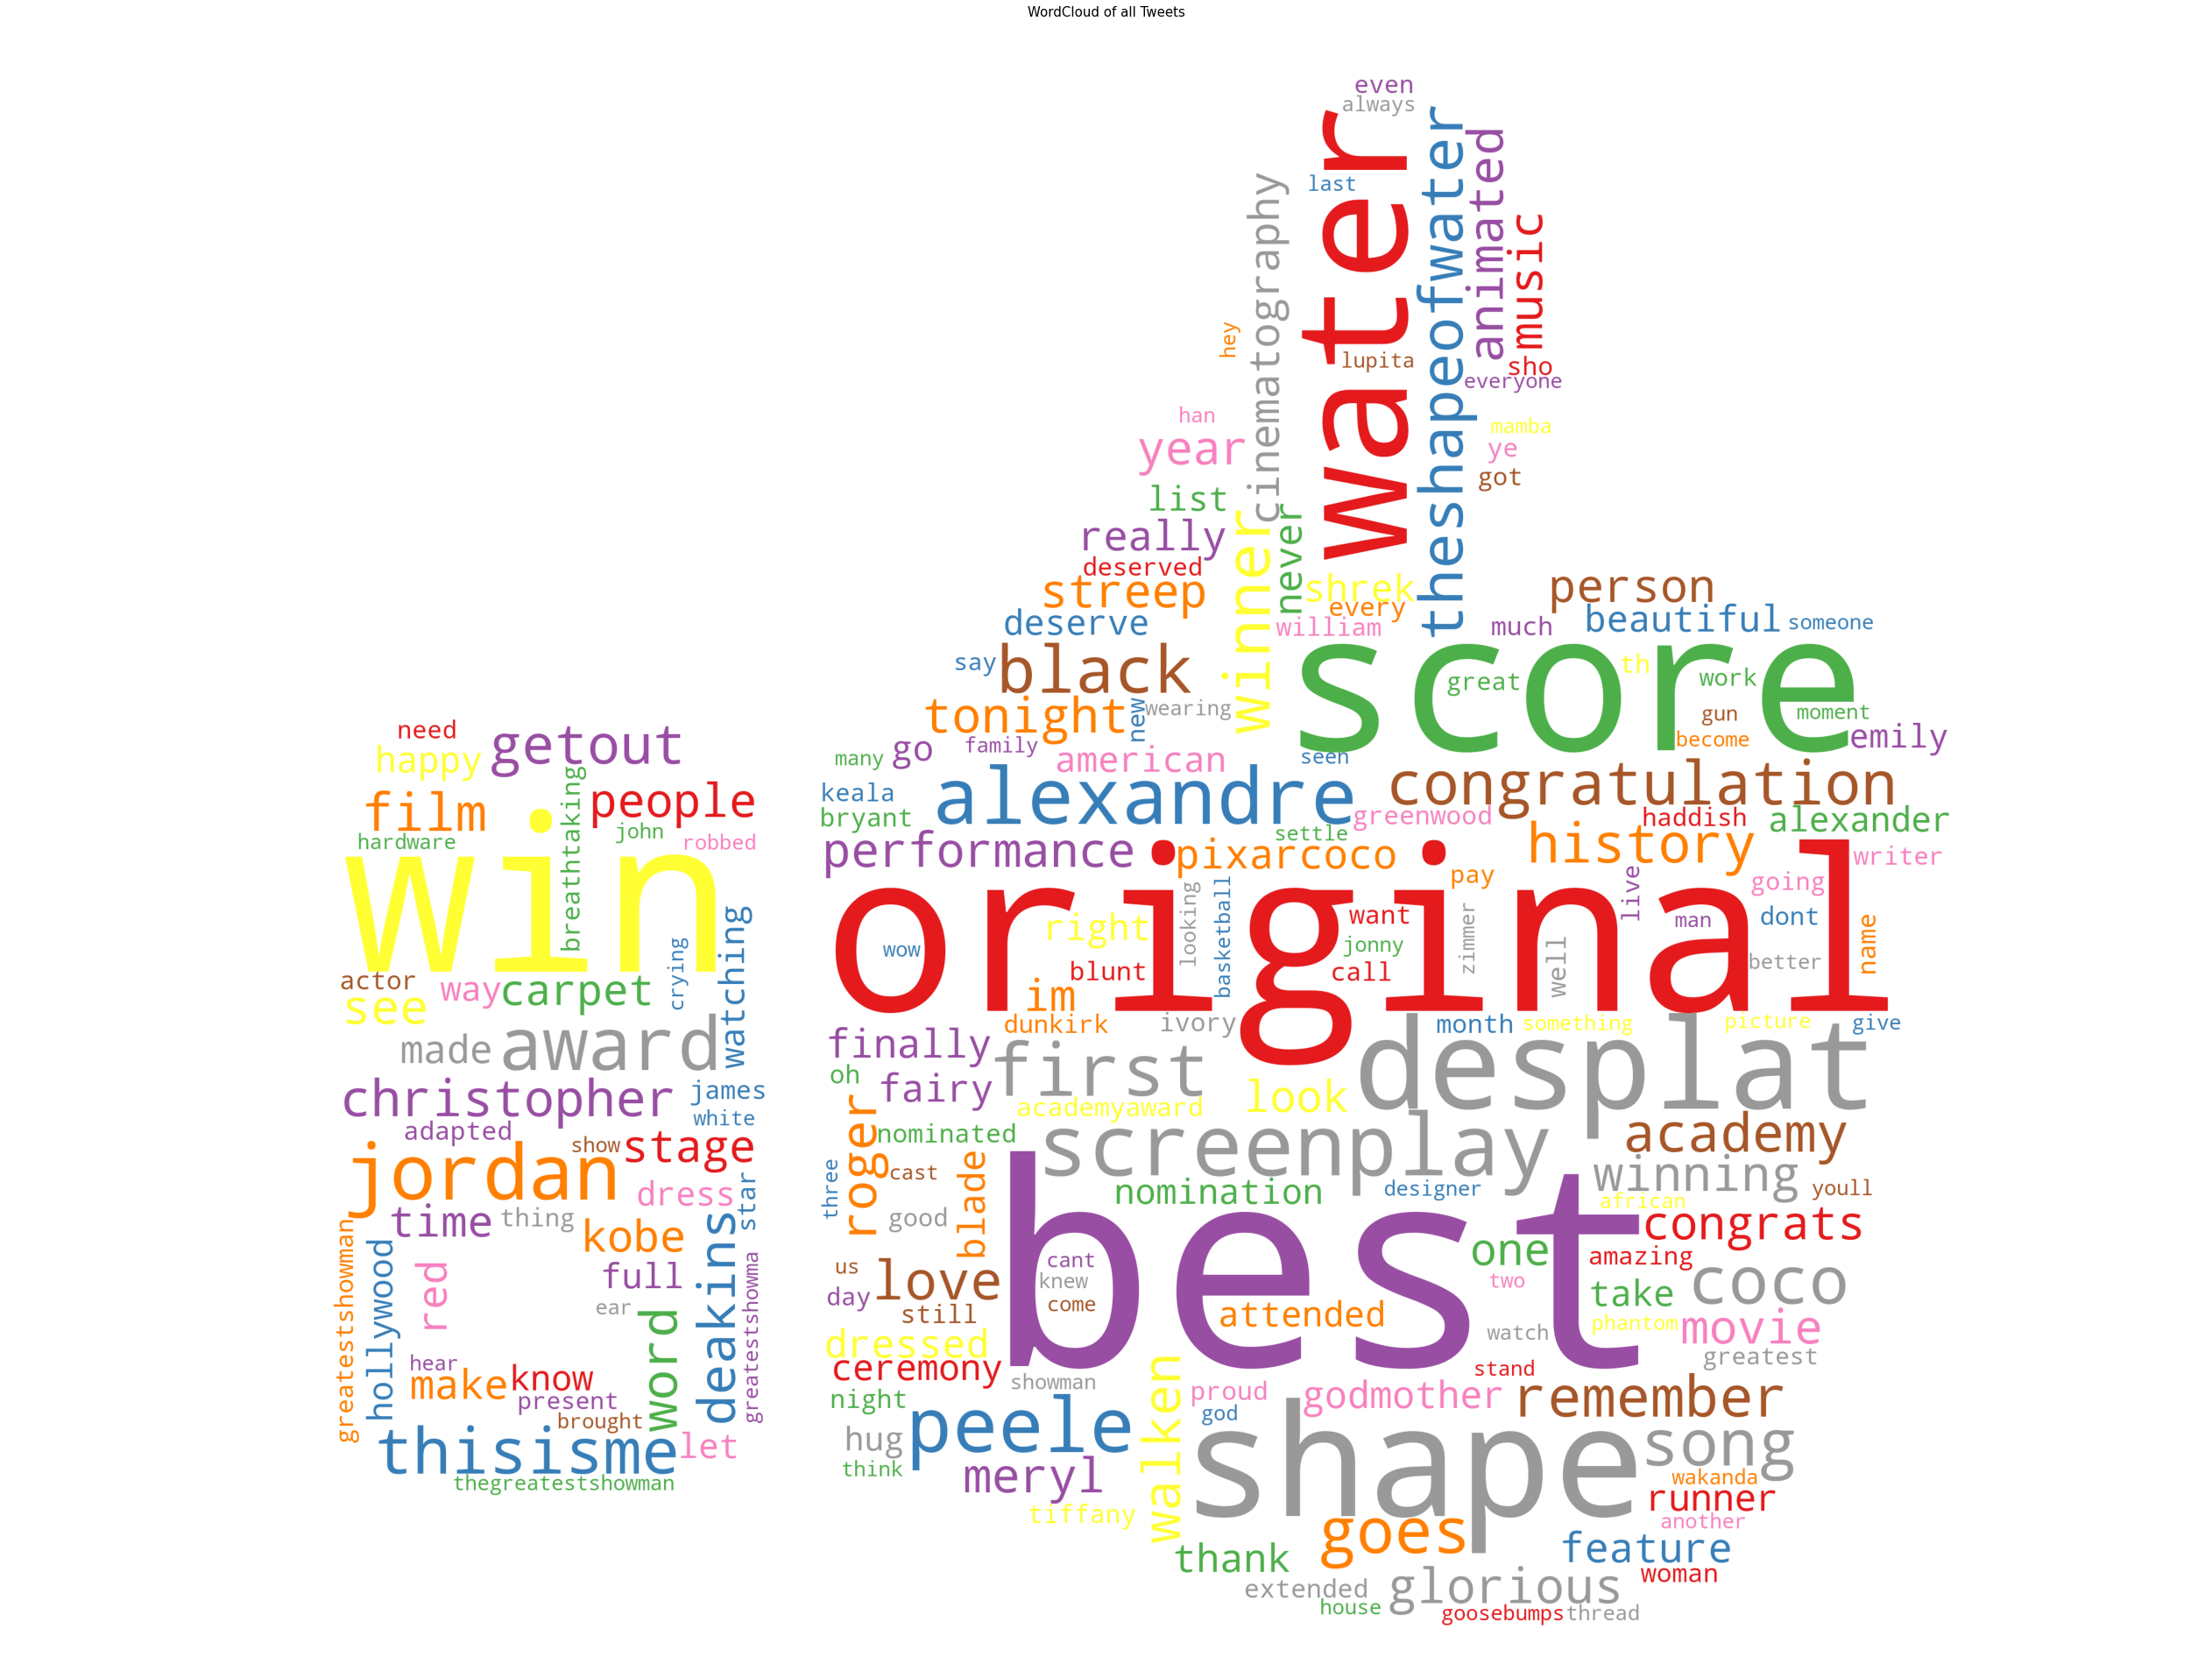

In [ ]:
# Word cloud for all Tweets

def show(cloud,title):
    plt.figure(figsize=(45,35))
    plt.imshow(cloud)
    plt.title(title, fontdict = {'fontsize':20}, size=15)
    plt.axis('off')

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from time import time

t = time()
# Generate word cloud
mask = np.array(Image.open('wo.png')) # This image and code file must be in same folder. I'll provide the image . A person should copy paste it in the Document Pivot file folder.
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='White', 
                      colormap='Set1', collocations=False, mask=mask ,stopwords=None).generate(final_text_single)
# Plot
show(wordcloud, 'WordCloud of all Tweets')
print("Total time taken : {} seconds".format(np.round((time()-t))))

## Step 9: TF-IDF


TF-IDF stands for (Term Frequency Inverse Document Frequency) It calculates the frequency of a particular term accurence accross all text . It calculate frequency in such a way that the resulting value ( in floats ) presents the importance of that term in whole text data.  

In [ ]:
## Here we have certain parameters to take care of :
## 'max_df' limits the terms that occurs more frequently than the threshold like 0.8 limits the terms that occured more then 80% 
## same for 'min_df' . This value must be in floats like 0.01, 0.001, 0.005 etc . A person can try different values and check the shape of tfidf_matrix .
## Below we have (20975, 365) it means we have 365 unique n-grams/words . 
## If we use 0.01 min_df threshold then we only left with 6 words ( not good ) . So a person can tweak it based on his needs.


from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df = 0.005, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_tweets'])


print(tfidf_matrix.shape)

CPU times: user 658 ms, sys: 5.47 ms, total: 663 ms
Wall time: 664 ms
(20975, 365)


In [ ]:
tf_idf_array = tfidf_matrix.toarray()
print(tf_idf_array.shape)

(20975, 365)


In [ ]:
terms = tfidf_vectorizer.get_feature_names()
pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names()).head()

,academy,academy award,academy award best,academyawards,actor,actress,actually,adapted,adapted screenplay,african,african american,...,words glorious,words glorious thisisme,work,wow,writer,writer win,writer win best,year,years,yes,zimmer
0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.193231,0.20526,0.214892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 10: Creating hierarchical dendogram

In [ ]:
## Calculating cosine similarity 

from sklearn.metrics.pairwise import cosine_similarity
%time dist = 1 - cosine_similarity(tfidf_matrix)
print(dist.shape)

In [ ]:
## It would take much time that's why I omitted the cell running
from scipy.cluster.hierarchy import ward, dendrogram, linkage
import matplotlib.pyplot as plt

t = time()
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

print("Total time taken : {} seconds".format(np.round((time()-t))))

# - [Phase 3](): Kmeans Clustering and visulaizing categories & associated terms

CPU times: user 248 ms, sys: 234 ms, total: 482 ms
Wall time: 243 ms


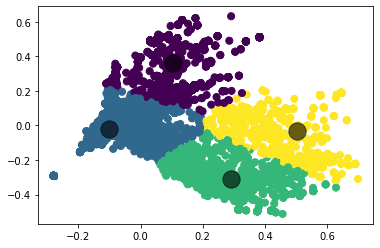

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

n_clusters = 4 #Defining No.of clusters
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

In [ ]:
prediction[:10]

array([2, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

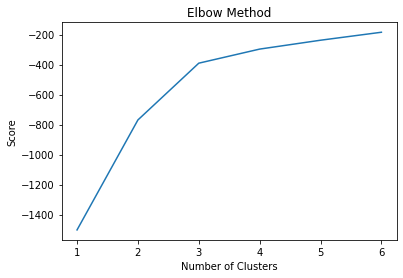

In [ ]:
# Elbow method just to check the suitable number of clusters

number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

## Step 11: Getting Top Terms/Subject associated with all predicted categories

In [ ]:
## Function for getting top terms per each cluster

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 25 scores
        features = tfidf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 25) #25 refers to No.of top terms we want

In [ ]:
dfs

[                    features     score
 0                       best  0.162501
 1                 screenplay  0.151903
 2                   original  0.150920
 3        original screenplay  0.146266
 4              best original  0.143364
 5   best original screenplay  0.130855
 6                      peele  0.120360
 7               jordan peele  0.120071
 8                     jordan  0.120024
 9         best original song  0.073444
 10             original song  0.071799
 11                       win  0.069351
 12                      song  0.068269
 13                 wins best  0.066280
 14                      wins  0.065239
 15         win best original  0.061006
 16                  win best  0.060521
 17                     black  0.059079
 18        wins best original  0.057665
 19                    person  0.044954
 20              black person  0.040322
 21                  remember  0.039814
 22                      coco  0.038218
 23          black person win  0.035561


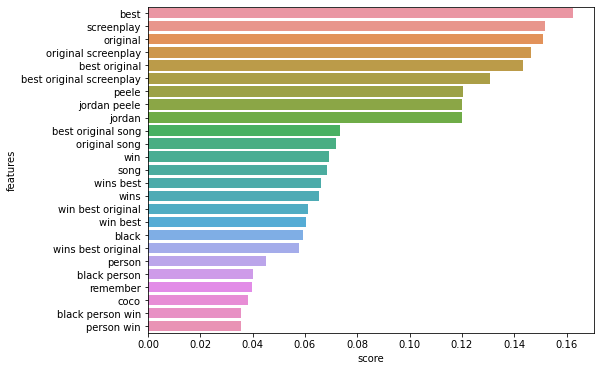

In [ ]:
# Visualizing top terms in 1st Cluster
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:25])

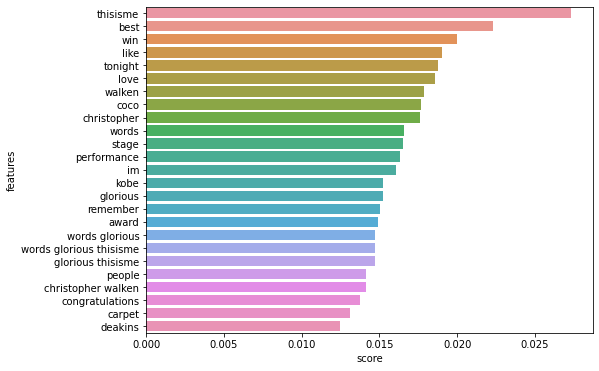

In [ ]:
# Visualizing top terms in 2nd Cluster
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:25])

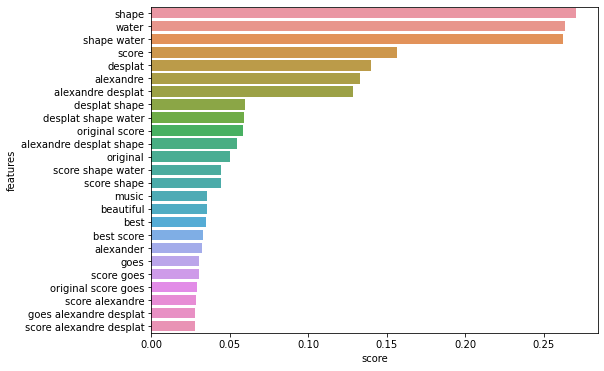

In [ ]:
# Visualizing top terms in 3rd Cluster
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:25])

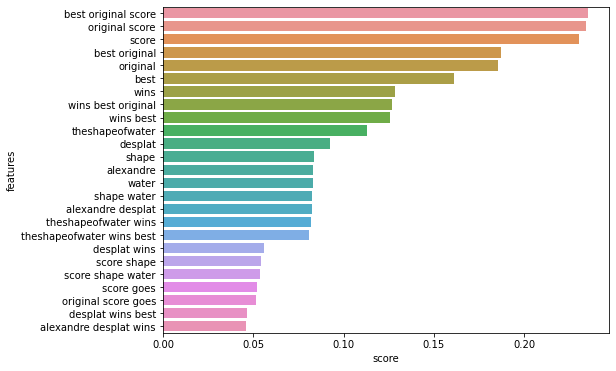

In [ ]:
# Visualizing top terms in 4th Cluster
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[3][:25])

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[4][:25])

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[5][:25])

In [ ]:
import numpy as np

dfs = np.array([                    features     score
 0                       best  0.162501
 1                 screenplay  0.151903
 2                   original  0.150920
 3        original screenplay  0.146266
 4              best original  0.143364
 5   best original screenplay  0.130855
 6                      peele  0.120360
 7               jordan peele  0.120071
 8                     jordan  0.120024
 9         best original song  0.073444
 10             original song  0.071799
 11                       win  0.069351
 12                      song  0.068269
 13                 wins best  0.066280
 14                      wins  0.065239
 15         win best original  0.061006
 16                  win best  0.060521
 17                     black  0.059079
 18        wins best original  0.057665
 19                    person  0.044954
 20              black person  0.040322
 21                  remember  0.039814
 22                      coco  0.038218
 23          black person win  0.035561
 24                person win  0.035561,                    features     score
 0                  thisisme  0.027353
 1                      best  0.022283
 2                       win  0.019966
 3                      like  0.019018
 4                   tonight  0.018779
 5                      love  0.018550
 6                    walken  0.017868
 7                      coco  0.017693
 8               christopher  0.017598
 9                     words  0.016577
 10                    stage  0.016521
 11              performance  0.016322
 12                       im  0.016060
 13                     kobe  0.015231
 14                 glorious  0.015223
 15                 remember  0.015044
 16                    award  0.014919
 17           words glorious  0.014698
 18  words glorious thisisme  0.014698
 19        glorious thisisme  0.014698
 20                   people  0.014117
 21       christopher walken  0.014112
 22          congratulations  0.013717
 23                   carpet  0.013120
 24                  deakins  0.012467,                    features     score
 0                     shape  0.270768
 1                     water  0.263623
 2               shape water  0.262203
 3                     score  0.156717
 4                   desplat  0.139714
 5                 alexandre  0.133082
 6         alexandre desplat  0.128508
 7             desplat shape  0.059449
 8       desplat shape water  0.059324
 9            original score  0.058292
 10  alexandre desplat shape  0.054431
 11                 original  0.050448
 12        score shape water  0.044245
 13              score shape  0.044189
 14                    music  0.035569
 15                beautiful  0.035469
 16                     best  0.035158
 17               best score  0.032811
 18                alexander  0.032253
 19                     goes  0.030741
 20               score goes  0.030691
 21      original score goes  0.028903
 22          score alexandre  0.028706
 23   goes alexandre desplat  0.028143
 24  score alexandre desplat  0.028116,                      features     score
 0         best original score  0.235418
 1              original score  0.234138
 2                       score  0.230303
 3               best original  0.187322
 4                    original  0.185294
 5                        best  0.161062
 6                        wins  0.128428
 7          wins best original  0.127065
 8                   wins best  0.125862
 9             theshapeofwater  0.112838
 10                    desplat  0.092752
 11                      shape  0.083383
 12                  alexandre  0.083310
 13                      water  0.083030
 14                shape water  0.082807
 15          alexandre desplat  0.082365
 16       theshapeofwater wins  0.081992
 17  theshapeofwater wins best  0.081050
 18               desplat wins  0.055796
 19                score shape  0.054081
 20          score shape water  0.053594
 21                 score goes  0.052223
 22        original score goes  0.051607
 23          desplat wins best  0.046725
 24     alexandre desplat wins  0.046039]
)
dfs

In [37]:
symbols = '{}[]()"",.;/+-_+='
import pandas as pd

c1 =             { "best":  0.162501,
                  "screenplay":  0.151903,
                    "original":  0.150920,
         "original screenplay":  0.146266,
               "best original":  0.143364,
    "best original screenplay":  0.130855,
                       "peele":  0.120360,
                "jordan peele":  0.120071,
                      "jordan":  0.120024,
          "best original song":  0.073444,
              "original song":  0.071799,
                        "win":  0.069351,
                       "song":  0.068269,
                  "wins best":  0.066280,
                       "wins":  0.065239,
          "win best original":  0.061006,
                   "win best":  0.060521,
                      "black":  0.059079,
         "wins best original":  0.057665,
                     "person":  0.044954,
               "black person":  0.040322,
                   "remember":  0.039814,
                       "coco":  0.038218,
           "black person win":  0.035561,
                 "person win":  0.035561 }

print("C1 type : ", type(c1), "\n")
print(c1.keys())
print(c1.values(), "\n")

c1df = pd.DataFrame(c1.keys(), c1.values())
c1df = c1df.reset_index()#.rename(columns = {"Score", "Feature"})
c1df = c1df.rename(columns = {"index":"Score", 0:"Feature"})
c1df

C1 type :  <class 'dict'> 

dict_keys(['best', 'screenplay', 'original', 'original screenplay', 'best original', 'best original screenplay', 'peele', 'jordan peele', 'jordan', 'best original song', 'original song', 'win', 'song', 'wins best', 'wins', 'win best original', 'win best', 'black', 'wins best original', 'person', 'black person', 'remember', 'coco', 'black person win', 'person win'])
dict_values([0.162501, 0.151903, 0.15092, 0.146266, 0.143364, 0.130855, 0.12036, 0.120071, 0.120024, 0.073444, 0.071799, 0.069351, 0.068269, 0.06628, 0.065239, 0.061006, 0.060521, 0.059079, 0.057665, 0.044954, 0.040322, 0.039814, 0.038218, 0.035561, 0.035561]) 



,Score,Feature
0,0.162501,best
1,0.151903,screenplay
2,0.150920,original
3,0.146266,original screenplay
4,0.143364,best original
5,0.130855,best original screenplay
6,0.120360,peele
7,0.120071,jordan peele
8,0.120024,jordan
9,0.073444,best original song


In [38]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
#plt.figure(figsize=(10,12), dpi=200)
fig = px.bar(c1df, x='Score', y='Feature')
fig.show()


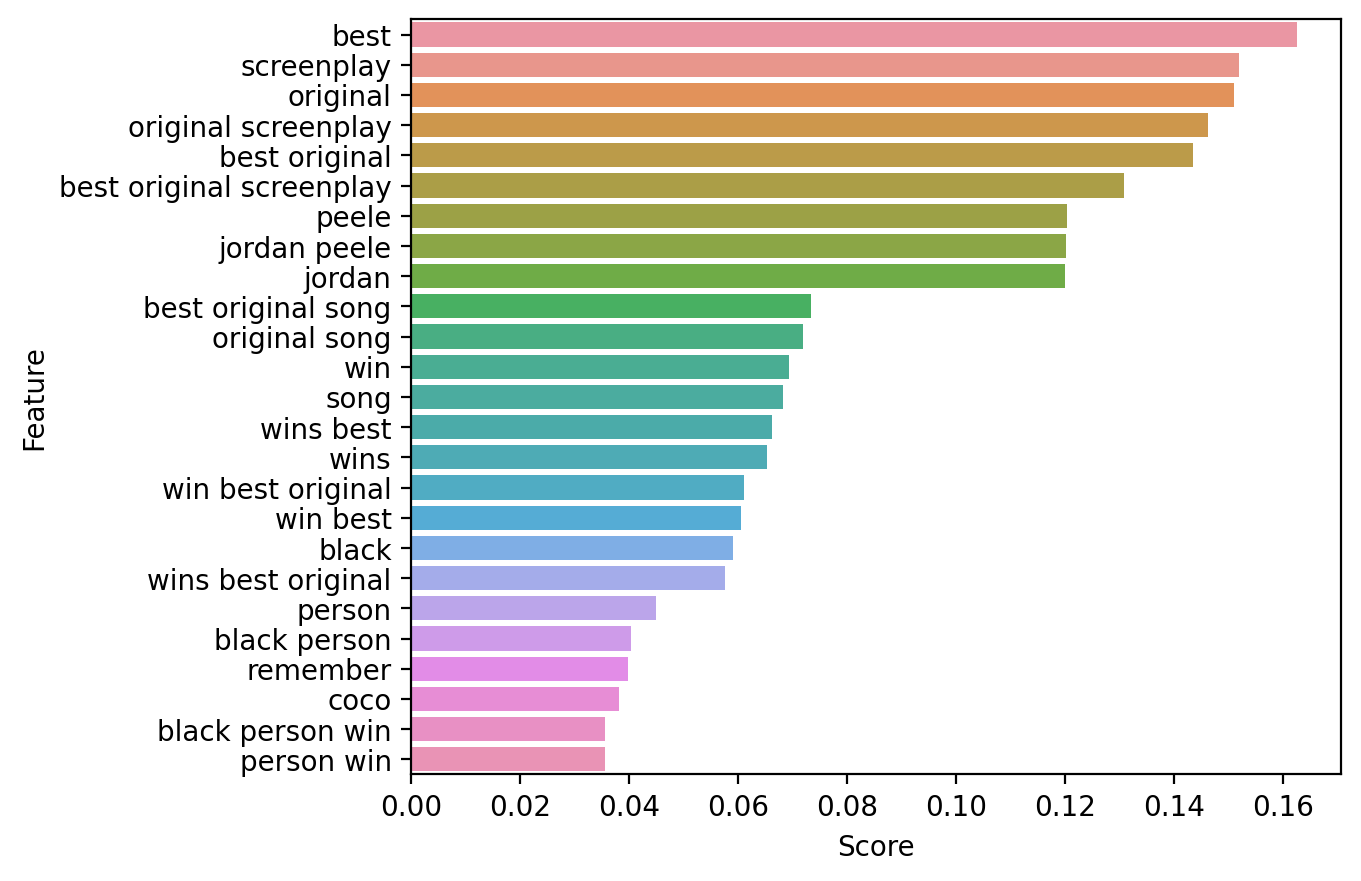

In [44]:
# High resolution
plt.figure(figsize=(6,5), dpi=200)
sns.barplot(x = 'Score' , y = 'Feature', orient = 'h' , data = c1df)

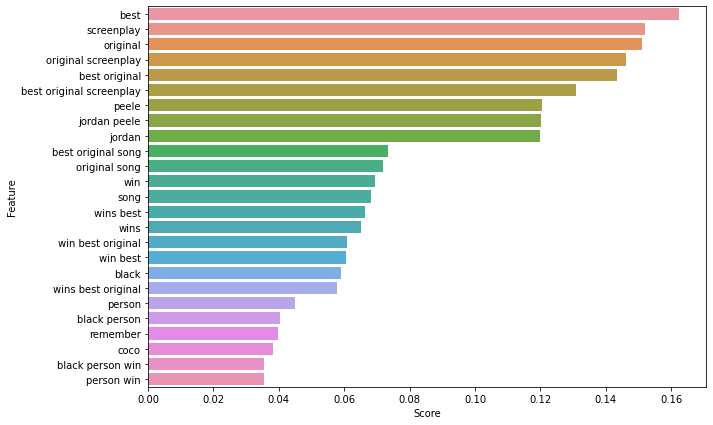

In [ ]:
# Low resolution
plt.figure(figsize=(10,7))
sns.barplot(x = 'Score' , y = 'Feature', orient = 'h' , data = c1df)